### Regression

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import (LinearRegression,Ridge,
                                  LogisticRegression,Lasso)
from sklearn.metrics import mean_squared_error,make_scorer,r2_score,median_absolute_error
from sklearn.neighbors import KNeighborsRegressor,LocalOutlierFactor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor,IsolationForest,
                                AdaBoostRegressor,StackingRegressor)
from sklearn.compose import TransformedTargetRegressor
from sklearn.cluster import KMeans, MeanShift
from lightgbm import LGBMRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (StratifiedShuffleSplit,StratifiedKFold,
                                     GridSearchCV,train_test_split,
                                     KFold,cross_val_score,RepeatedKFold,cross_validate,
                                    cross_val_predict)

from sklearn.preprocessing import (StandardScaler,RobustScaler,
                                PolynomialFeatures,OrdinalEncoder,
                                   FunctionTransformer,OneHotEncoder)


from time import time
from tqdm.notebook import tqdm

from transformers import *

#ESTO DEBERA IR EN EL DATACLEANING
def filter_categorical(X,columns):
    for column in columns:
        if column in ["language","country","director"]:
            sl = short_list(data=X,column=column,min_amount=10,len_limit=5)
            X.loc[~X[column].isin(sl.index),column] = 'OTHER'
        else:
            sl = short_list(data=X,column=column,min_amount=10)
            X.loc[~X[column].isin(sl.index),column] = 'OTHER'
    return X

def filter_small(X,column="income_adj",quantile=0.1):
    min = X[column].quantile(quantile)
    return X.drop(X[X[column]<min].index)

ModuleNotFoundError: No module named 'tqdm'

In [74]:
plt.style.use("bmh")
plt.style.use("dark_background")
data = pd.read_csv(r"preprocessed_data") 

data.columns

#Filter data to use
data = data[data["year"]>=2000]
data = filter_small(data,quantile=0.1)

df_for_model = data.copy()[['actors0', 'genre0',
       'production_company', 'duration', 'writer','director', 'date_published',
       'budget_adj','language',"income_adj","country"]]
#Define Target
y = data.copy()[["income_adj"]]



COLS_TO_ENCODE = ['genre0','writer','language',"country","director",
                  "actors0","production_company"]
DATE_COLUMN = "date_published"
filter_categorical(X=df_for_model,columns=COLS_TO_ENCODE)
#df_for_model = filter_small(df_for_model)



#Create train and test set
df_train,df_test,y_train,y_test = train_test_split(df_for_model,y,
                                                   test_size=0.3,
                                                   random_state=42)

#prepare scorers for modeling
rmse = make_scorer(mean_squared_error)
scoring = {"r2":make_scorer(r2_score),"rmse":rmse}



#### BaseLine Model: Linear regression 

In [73]:
BASE_FEATURES = ["duration","budget_adj"]
X_train_lr = df_train[BASE_FEATURES]

pipe = Pipeline([("linearRegression",LinearRegression())])

scores = cross_val_score(pipe,X=X_train_lr,y=y_train,cv=10,scoring="r2")

print(f"BaseLine model: {scores.mean()}, {scores.std()}")


BaseLine model: 0.5902512525982231, 0.05206575224650734


In [70]:
def plot_results(model,X,y,c=None,cmap=None):
    y_hat = cross_val_predict(model,X,y,cv=10)
    fig,ax = plt.subplots()
    ax.scatter(y,y_hat,alpha=0.5,c=c,cmap=cmap)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], "y--", lw=3)
    ax.set_xlabel("Messured")
    ax.set_ylabel("Predictied")
    plt.show()

#### Linear Regressor

In [71]:
dates_transformer = Pipeline(steps=[("create_features",Dates_enginering("date_published")),
                                ("encode",OneHotEncoder())])
cat_transformer = OneHotEncoder(handle_unknown="ignore",sparse=False)
num_transformer = RobustScaler()
outlier_detector = OutlierDetection(IsolationForest(random_state=0,
                                                   n_estimators=10,
                                                  contamination=0.05))
lr_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("num",num_transformer,["budget_adj","duration"])
])


lr = Pipeline(steps=[("preprocessor",lr_preprocessor),
                     ("outlier_detector",outlier_detector),
                     ("regressor",Ridge())])
param_grid = [    
     {
         "regressor__alpha":[1,10,100,1000,500,400,700,50]
     }
]
grid = GridSearchCV(lr,param_grid=param_grid,
                    cv=5,
                    scoring=scoring,return_train_score=True,n_jobs=-1,
                    verbose=10,
                    error_score="raise",
                    refit="r2")
grid.fit(df_train,y_train.values.ravel())

print(grid.best_score_)
print(grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.5989332521701067
{'regressor__alpha': 100}


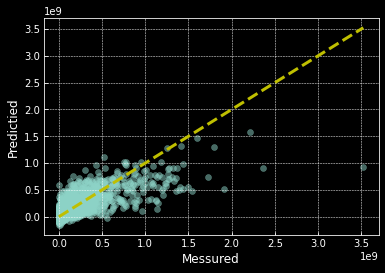

In [72]:
plot_results(lr,df_train,y_train)

#### RandomForest

In [25]:
dates_transformer = Pipeline(steps=[("create_dates",Dates_enginering("date_published"))])

cat_transformer = OrdinalEncoder()
num_transformer = RobustScaler()
preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("numerical",num_transformer,["duration","budget_adj"])
])

rf = Pipeline(steps=[("preprocessor",preprocessor),("regressor",RandomForestRegressor())])
forest_param_grid = [
    {"regressor__max_depth":[5],
     "regressor__min_samples_split":[2,3,4],
     "regressor__n_estimators":[400,450,475]
    }]



forest_grid = GridSearchCV(rf,param_grid=forest_param_grid,
                    cv=5,
                    scoring=scoring,return_train_score=True,n_jobs=-1,
                    verbose=10,
                    error_score="raise",
                    refit="r2")
forest_grid.fit(df_train,y_train.values.ravel())
best_forest_model = forest_grid.best_estimator_
print(best_forest_model)
print(forest_grid.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


KeyboardInterrupt: 

#### KNN

In [37]:
dates_transformer = Pipeline(steps=[("create_dates",Dates_enginering("date_published")),
                                ("encode_dates",OneHotEncoder(handle_unknown="ignore"))])

cat_transformer = OrdinalEncoder()
num_transformer = RobustScaler()
#outlier_detector = OutlierDetection(IsolationForest(random_state=0,
                                                  # n_estimators=10,
                                                  #contamination=0.05))
preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("numerical",num_transformer,["duration","budget_adj"])
])

knn = Pipeline(steps=[("preprocessor",preprocessor),
                      
                      ("regressor",KNeighborsRegressor())])
knn_param_grid = [
    {"regressor__n_neighbors":[5,10,15,50,100,200],
     "preprocessor__encode_cat":[OrdinalEncoder(),OneHotEncoder(sparse=False)]
    }]
knn_grid = GridSearchCV(knn,param_grid=knn_param_grid,
                    cv=5,
                    scoring=scoring,return_train_score=True,n_jobs=-1,
                    verbose=10,
                    error_score="raise",
                    refit="r2")
knn_grid.fit(df_train,y_train.values.ravel())
best_knn_model = knn_grid.best_params_
print(best_knn_model)
print(knn_grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'preprocessor__encode_cat': OneHotEncoder(sparse=False), 'regressor__n_neighbors': 15}
0.5370949651277578


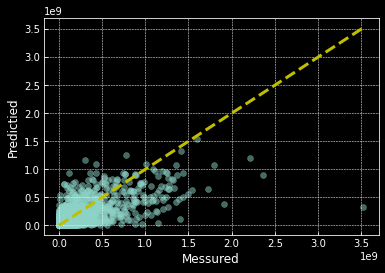

In [10]:
plot_results(knn,df_train,y_train)

#### AdaBoost

In [130]:
dates_transformer = Pipeline(steps=[("create_dates",
                                     Dates_enginering("date_published"))])

cat_transformer = OrdinalEncoder()
num_transformer = RobustScaler()
preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("numerical",num_transformer,["duration","budget_adj"])
])

ada = Pipeline(steps=[("preprocessor",preprocessor),
                      ("regressor",AdaBoostRegressor())])
ada_param_grid = [
    {
     "regressor__n_estimators":[445,450,455,460,470],
     "regressor__learning_rate":[0.001],

    }]
ada_grid = GridSearchCV(ada,param_grid=ada_param_grid,                    
                    cv=10,
                    scoring=scoring,return_train_score=True,n_jobs=-1,
                    verbose=10,
                    error_score="raise",
                    refit="r2")
ada_grid.fit(df_train,y_train.values.ravel())
best_ada_model = ada_grid.best_params_
print(best_ada_model)
print(ada_grid.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
{'regressor__learning_rate': 0.001, 'regressor__n_estimators': 455}
0.610995212031642


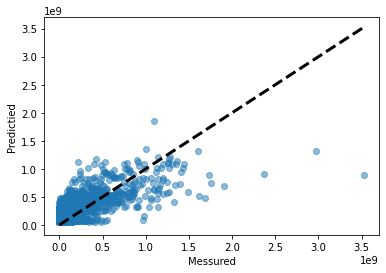

In [131]:
plot_results(ada,df_train,y_train.values.ravel())

#### Outlier detection

In [21]:
# Isolation forest
dates_transformer = Pipeline(steps=[("create_dates",
                                     Dates_enginering("date_published"))])

cat_transformer = OrdinalEncoder()
num_transformer = StandardScaler()
preprocessor = ColumnTransformer([
    #"encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("numerical",num_transformer,["budget_adj"])
])

iso_f = Pipeline(steps=[("preprocessor",preprocessor),
                      ("regressor",IsolationForest(random_state=0,
                                                   n_estimators=10,
                                                  contamination=0.05))])

isof_results = cross_val_predict(iso_f,df_train)

# Kmeans
kmeans =  Pipeline(steps=[("preprocessor",preprocessor),
                      ("regressor",KMeans(2))])
kmeans_results = cross_val_predict(kmeans,df_train)

#LocalOutlierFactor

loa = Pipeline(steps=[("preprocessor",preprocessor),
                      ("regressor",LocalOutlierFactor(n_neighbors=10,novelty=True))])
loa_results = cross_val_predict(loa,df_train)

In [22]:
outliers = pd.DataFrame({"isof":isof_results,
                         "kmeans":kmeans_results,
                         "loa":loa_results,
                         "income_adj":y_train.values.ravel(),
                         "budget_adj":df_train["budget_adj"]})


In [23]:
df_train.loc[outliers.index,"outliers"] = outliers["isof"]

In [24]:
df_train.loc[:,"outliers1"] = isof_results

In [25]:
df_train

,actors0,genre0,production_company,duration,writer,director,date_published,budget_adj,language,country,outliers,outliers1
5930,OTHER,Action,OTHER,128,OTHER,OTHER,2009-10-16,2.526091e+06,OTHER,OTHER,1,1
8611,OTHER,Action,OTHER,163,OTHER,OTHER,2016-10-28,8.467566e+06,OTHER,OTHER,1,1
3507,OTHER,Animation,OTHER,72,OTHER,OTHER,2003-04-04,2.945326e+07,English,USA,1,1
8011,OTHER,Action,OTHER,105,OTHER,OTHER,2016-09-29,1.714877e+07,Mandarin,OTHER,1,1
5191,OTHER,Drama,OTHER,96,OTHER,OTHER,2007-09-28,7.841248e+06,OTHER,UK,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6978,Brad Pitt,Crime,OTHER,97,OTHER,OTHER,2012-10-18,1.770321e+07,English,USA,1,1
8609,OTHER,Animation,OTHER,78,OTHER,OTHER,2016-10-11,3.951531e+06,English,USA,-1,-1
8645,OTHER,Comedy,OTHER,100,OTHER,OTHER,2018-01-19,8.622577e+05,OTHER,OTHER,1,1
8833,OTHER,Comedy,OTHER,95,OTHER,OTHER,2019-10-31,2.119793e+06,OTHER,OTHER,1,1


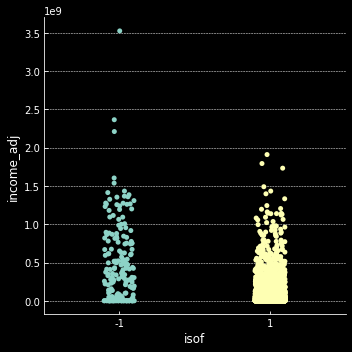

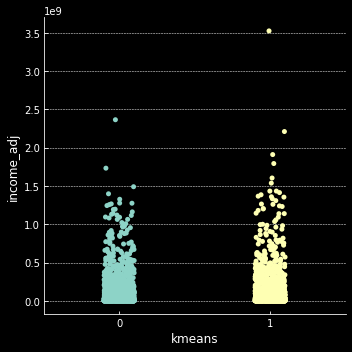

In [45]:
sns.catplot(x="isof",y="income_adj",data=outliers)
sns.catplot(x="kmeans",y="income_adj",data=outliers)

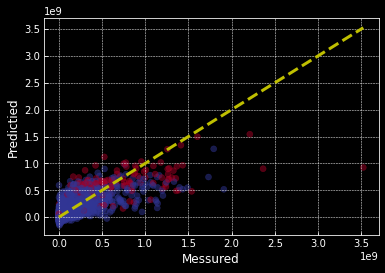

In [46]:
plot_results(lr,df_train,y_train,c=outliers["isof"],cmap="RdYlBu")

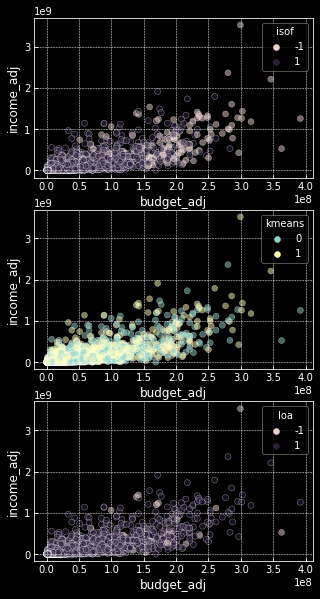

In [47]:
fig,ax = plt.subplots(nrows=3,figsize=(5,10))
for i,detector in enumerate(["isof","kmeans","loa"]):
    sns.scatterplot(data=outliers,x="budget_adj",
                    y="income_adj",hue=detector,alpha=0.5,ax=ax[i])


#### Cloustering

#### Stacking

In [7]:
level0 = list()
#dates prepo is common for all models
dates_transformer = Pipeline(steps=[("create_features",Dates_enginering("date_published")),
                                ("encode",OneHotEncoder(handle_unknown="ignore"))])
# Linear
cat_transformer = OneHotEncoder(handle_unknown="ignore")
num_transformer = RobustScaler()
lr_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("num",num_transformer,["budget_adj","duration"])
])
lr = Pipeline(steps=[("preprocessor",lr_preprocessor),
                     ("regressor",Ridge(alpha=10))])
level0.append(("lr",lr))

#KNN
cat_transformer = OneHotEncoder()
num_transformer = RobustScaler()
knn_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("numerical",num_transformer,["duration","budget_adj"])
])

knn = Pipeline(steps=[("preprocessor",knn_preprocessor),
                      ("regressor",KNeighborsRegressor(n_neighbors=15))])
level0.append(("knn",knn))

#RandomForest
dates_transformer = Pipeline(steps=[
                            ("create_dates",Dates_enginering("date_published"))
                            ])
cat_transformer = OrdinalEncoder()
num_transformer = RobustScaler()
rf_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("numerical",num_transformer,["duration","budget_adj"])
])

rf = Pipeline(steps=[("preprocessor",rf_preprocessor),
                     ("regressor",RandomForestRegressor(max_depth=5,
                                                        min_samples_split=3,
                                                        n_estimators=450))])

level0.append(("rf",rf))

#AdaBoost
dates_transformer = Pipeline(steps=[
                            ("create_dates",Dates_enginering("date_published"))
                            ])
cat_transformer = OrdinalEncoder()
num_transformer = RobustScaler()
ada_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("numerical",num_transformer,["duration","budget_adj"])
])

ada = Pipeline(steps=[("preprocessor",ada_preprocessor),
                      ("regressor",AdaBoostRegressor(learning_rate=0.001,
                                                     n_estimators=450))])
level0.append(("ada",ada))

#Isolation Forest

dates_transformer = Pipeline(steps=[("create_dates",
                                     Dates_enginering("date_published"))])

cat_transformer = OrdinalEncoder()
num_transformer = StandardScaler()
preprocessor = ColumnTransformer([
    #"encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("numerical",num_transformer,["budget_adj"])
])

iso_f = Pipeline(steps=[("preprocessor",preprocessor),
                      ("regressor",IsolationForest(random_state=0,
                                                   n_estimators=10,
                                                  contamination=0.05))])
level0.append(("isof",iso_f))
#Define level1 model
level1 = LinearRegression()

#Create Stack model
stack_model = StackingRegressor(estimators=level0,final_estimator=level1,cv=5)


def evaluate_model(model,X,y,scoring="r2"):
    cv = RepeatedKFold(n_splits=10,n_repeats=3,random_state=1)
    scores = cross_val_score(model,X,y,scoring=scoring,
                            cv=cv,n_jobs=-1,error_score="raise")
    return scores

In [8]:
stack_scores = evaluate_model(stack_model,df_train,y_train)

ValueError: The estimator Pipeline should be a regressor.

In [103]:
plot_results(model=stack_model,X=df_train,y=y_train.values.ravel())

ValueError: Found unknown categories ['Emmett/Furla/Oasis Films (EFO Films)'] in column 6 during transform

### Classification

In [1]:
#Manipulating
import pandas as pd
import numpy as np
#plot

#import matplotlib.pyplot as plt
#import seaborn as sns
#Sklearn imports
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import (LogisticRegression,RidgeClassifier,SGDClassifier)
from sklearn.metrics import (precision_recall_curve,
                             average_precision_score,
                            PrecisionRecallDisplay,f1_score,confusion_matrix)
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,StackingClassifier,VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (StratifiedShuffleSplit,StratifiedKFold,
                                     GridSearchCV,RandomizedSearchCV,train_test_split,
                                     KFold,cross_val_score,RepeatedKFold,cross_validate,
                                    cross_val_predict)
from sklearn.preprocessing import (StandardScaler,RobustScaler,
                                PolynomialFeatures,OrdinalEncoder,
                                   FunctionTransformer,OneHotEncoder,
                                   LabelBinarizer,LabelEncoder)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

from lightgbm import LGBMClassifier
#TensorFlow imports
#import keras_tuner as kt
from tensorflow.keras import Sequential,Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout,Dense,Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#Utils
from transformers import short_list, Dates_enginering
from util_plots import *

#### Basic 

In [9]:

data = pd.read_csv(r"preprocessed_data") 



#Filter data to use
data = data[data["year"]>=1970]


df_for_model = data.copy()[['actors0', 'genre0',
       'production_company', 'duration', 'writer','director', 'date_published',
       'budget_adj','language',"income_adj","country"]]

COLS_TO_ENCODE = ['genre0','writer','language',"country","director",
                  "actors0","production_company"]

n_classes = 4
df_for_model["bin_income"] = pd.qcut(df_for_model["income_adj"],q=[0,0.4,0.7,0.95,1],
                                     labels=["low","medium","big","tank"])
y = df_for_model["bin_income"]
label = LabelEncoder()
y = label.fit_transform(y)
#Create train and test set
df_train,df_test,y_train,y_test = train_test_split(df_for_model,y,
                                                   test_size=0.2,
                                                   )

df_train.drop(columns=["income_adj","bin_income"],inplace=True)
df_test.drop(columns=["income_adj","bin_income"],inplace=True)

#y_train_ordinal = LabelEncoder().fit_transform(label.inverse_transform(y_train))
#Dictionary for best models found in grid
models = dict()

In [10]:
df_train

,actors0,genre0,production_company,duration,writer,director,date_published,budget_adj,language,country
1645,Kevin Kline,Comedy,Warner Bros.,110,Gary Ross,OTHER,1993-05-07,5.250630e+07,English,USA
7365,OTHER,Drama,OTHER,120,OTHER,OTHER,2015-08-28,3.429754e+06,English,USA
1011,Jason Bateman,Comedy,OTHER,95,OTHER,OTHER,1987-11-20,7.155898e+06,English,USA
2927,OTHER,Action,Regency Enterprises,97,OTHER,OTHER,2002-06-14,3.519091e+07,English,USA
4049,OTHER,Adventure,OTHER,99,OTHER,OTHER,2006-07-20,1.344097e+07,English,USA
...,...,...,...,...,...,...,...,...,...,...
6344,OTHER,Adventure,OTHER,109,OTHER,OTHER,2011-11-17,1.023942e+07,OTHER,Germany
728,OTHER,Adventure,Constantin Film,102,OTHER,OTHER,1984-12-06,7.041569e+07,English,OTHER
7488,OTHER,Biography,OTHER,119,OTHER,OTHER,2016-04-07,2.088666e+07,French,France
1078,OTHER,Action,OTHER,88,Keenen Ivory Wayans,OTHER,1989-02-23,6.871598e+06,English,USA


In [4]:
dates_transformer = Pipeline(steps=[("create_features",Dates_enginering("date_published")),
                                ("encode",OrdinalEncoder())])
cat_transformer = OrdinalEncoder()
num_transformer = StandardScaler()
lr_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("num",num_transformer,["budget_adj","duration"])
])
rf = RandomForestClassifier(max_depth=90,min_samples_split=4)
pipe = Pipeline(steps=[("dates",dates_transformer),("cat",cat_transformer),("num",num_transformer),("clf",rf)])
pipe.fit(df_train,y_train)
scores = cross_val_predict(pipe,df_train,y_train)

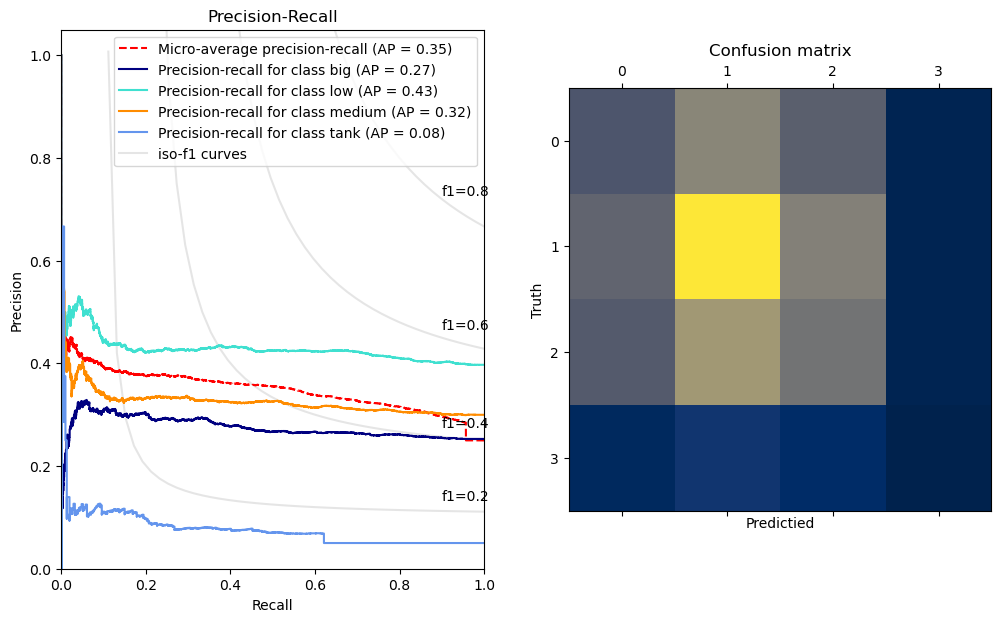

F1 score(average): 0.36202773792443804


In [5]:
get_results(model=pipe,X=df_train,y=y_train)

AttributeError: 'Dates_enginering' object has no attribute 'n_features_in_'

#### General models

In [14]:
scores = dict()

#Logistic Regression
dates_transformer = Pipeline(steps=[("create_features",Dates_enginering("date_published")),
                                ("encode",OneHotEncoder(handle_unknown="ignore"))])
cat_transformer = OneHotEncoder(handle_unknown="ignore")
num_transformer = StandardScaler()
lr_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("num",num_transformer,["budget_adj","duration"])
])

log_reg = OneVsRestClassifier(Pipeline(steps=[("preprocessor",lr_preprocessor),
                     ("clf",LogisticRegression(max_iter=200))]))
log_reg_scores = cross_val_predict(log_reg,df_train,y_train,
                                  method="predict_proba")
scores["log_reg"]= log_reg_scores
#SGD
sgd = OneVsRestClassifier(Pipeline(steps=[("preprocessor",lr_preprocessor),
                     ("clf",SGDClassifier(loss="log"))]))
sgd_scores = cross_val_predict(sgd,df_train,y_train,
                                   method="predict_proba")
scores["sgd"] = sgd_scores
#RandomForest
dates_transformer_rf = Pipeline(steps=[
                    ("create_features",Dates_enginering("date_published")),
                    ("encode",OrdinalEncoder())
                    ])
cat_transformer_rf = OrdinalEncoder(unknown_value=999,handle_unknown='use_encoded_value')
rf_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer_rf,COLS_TO_ENCODE),
    ("dates",dates_transformer_rf,"date_published"),
    ("num",num_transformer,["budget_adj","duration"])
])
rf =  OneVsRestClassifier(Pipeline(steps=[("preprocessor",rf_preprocessor),
                     ("clf",RandomForestClassifier())]))
rf_scores = cross_val_predict(rf,df_train,y_train,
                                   method="predict_proba")
scores["rf"] = rf_scores
#AdaBoost
dates_transformer_ada = Pipeline(steps=[
                    ("create_features",Dates_enginering("date_published")),
                    ("encode",OrdinalEncoder())
                    ])
cat_transformer_ada = OrdinalEncoder(unknown_value=999,handle_unknown='use_encoded_value')
ada_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer_ada,COLS_TO_ENCODE),
    ("dates",dates_transformer_ada,"date_published"),
    ("num",num_transformer,["budget_adj","duration"])
])
ada = OneVsRestClassifier(Pipeline(steps=[("preprocessor",ada_preprocessor),
                     ("clf",AdaBoostClassifier())]))
ada_scores = cross_val_predict(ada,df_train,y_train,
                                   method="predict_proba")
scores["ada"] = ada_scores
#Lightgbm
dates_transformer_lgbm = Pipeline(steps=[
                    ("create_features",Dates_enginering("date_published")),
                    ("encode",OrdinalEncoder())
                    ])
cat_transformer_lgbm = OrdinalEncoder(unknown_value=999,handle_unknown='use_encoded_value')
lgbm_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer_lgbm,COLS_TO_ENCODE),
    ("dates",dates_transformer_lgbm,"date_published"),
    ("num",num_transformer,["budget_adj","duration"])
])
lgbm = OneVsRestClassifier(Pipeline(steps=[("preprocessor",lgbm_preprocessor),
                     ("clf",LGBMClassifier())]))
lgbm_scores = cross_val_predict(lgbm,df_train,y_train,
                                   method="predict_proba")
scores["lgbm"] = lgbm_scores

#### Logistic Regression

In [ ]:
dates_transformer = Pipeline(steps=[("create_features",Dates_enginering("date_published")),
                                ("encode",OneHotEncoder(handle_unknown="ignore"))])
cat_transformer = OneHotEncoder(handle_unknown="ignore")
num_transformer = StandardScaler()
log_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer,COLS_TO_ENCODE),
    ("dates",dates_transformer,"date_published"),
    ("num",num_transformer,["budget_adj","duration"])
])

C = [0.15]
l1_ratio = [0.1]
param_grid = dict(estimator__clf__l1_ratio=l1_ratio,
                  estimator__clf__C=C)

log_reg = Pipeline(steps=[("preprocessor",log_preprocessor),
                        ("clf",LogisticRegression(max_iter=500,penalty="elasticnet",solver="saga"))])
log_grid = GridSearchCV(log_reg,param_grid=param_grid,cv=5,n_jobs=-1,verbose=3)
log_grid.fit(df_train,y_train)
#scores["log_reg"]= log_reg_scores
#mejor primer tirada: C:0.1,l1_ratio:0
#mejor segunda tirada : C:0.15, l1_ratio:0.1

models["log_reg"] = log_grid.best_estimator_
get_results(models["log_reg"],df_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


#### Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END clf__max_depth=90, clf__min_samples_split=4;, score=0.609 total time=   0.3s
[CV 2/5] END clf__max_depth=90, clf__min_samples_split=4;, score=0.622 total time=   0.2s
[CV 3/5] END clf__max_depth=90, clf__min_samples_split=4;, score=0.613 total time=   0.2s
[CV 4/5] END clf__max_depth=90, clf__min_samples_split=4;, score=0.622 total time=   0.2s
[CV 5/5] END clf__max_depth=90, clf__min_samples_split=4;, score=0.648 total time=   0.3s


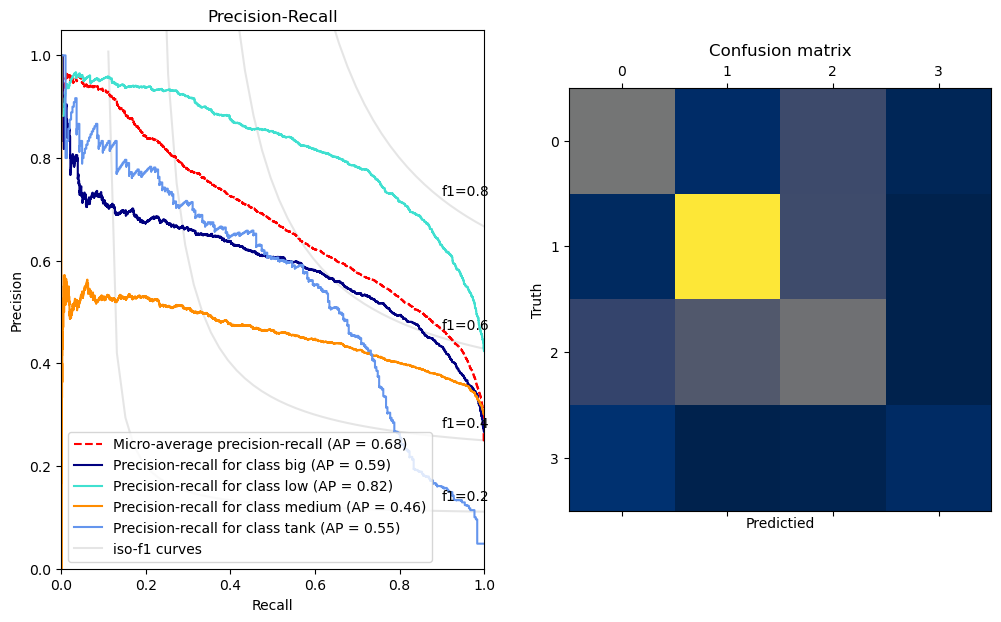

F1 score(average): 0.6194803124501833


In [17]:
dates_transformer_rf = Pipeline(steps=[
                    ("create_features",Dates_enginering("date_published")),
                    ("encode",OrdinalEncoder())
                    ])
cat_transformer_rf = OrdinalEncoder(unknown_value=999,handle_unknown='use_encoded_value')
rf_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer_rf,COLS_TO_ENCODE),
    ("encode_dates",dates_transformer_rf,"date_published"),
    ("num","passthrough",["budget_adj","duration"])
])

rf =  Pipeline(steps=[("preprocessor",rf_preprocessor),
                                            ("clf",RandomForestClassifier(n_jobs=-1,n_estimators=100))])
max_depth = [90]
min_samples_split = [4]
param_grid = dict(clf__max_depth=max_depth,
                  clf__min_samples_split=min_samples_split)

rf_grid = GridSearchCV(rf,param_grid=param_grid,cv=5,verbose=3)
rf_grid.fit(df_train,y_train)


models["rf"] = rf_grid.best_estimator_
#Mejor primera tirada: max_depth:100, min_samples_split:5
#Mejor segunda tirada: max_depth:90,min_samples_split:4
#PCA no mejora el modelo
get_results(models["rf"],df_train,y_train)

#### LGBM

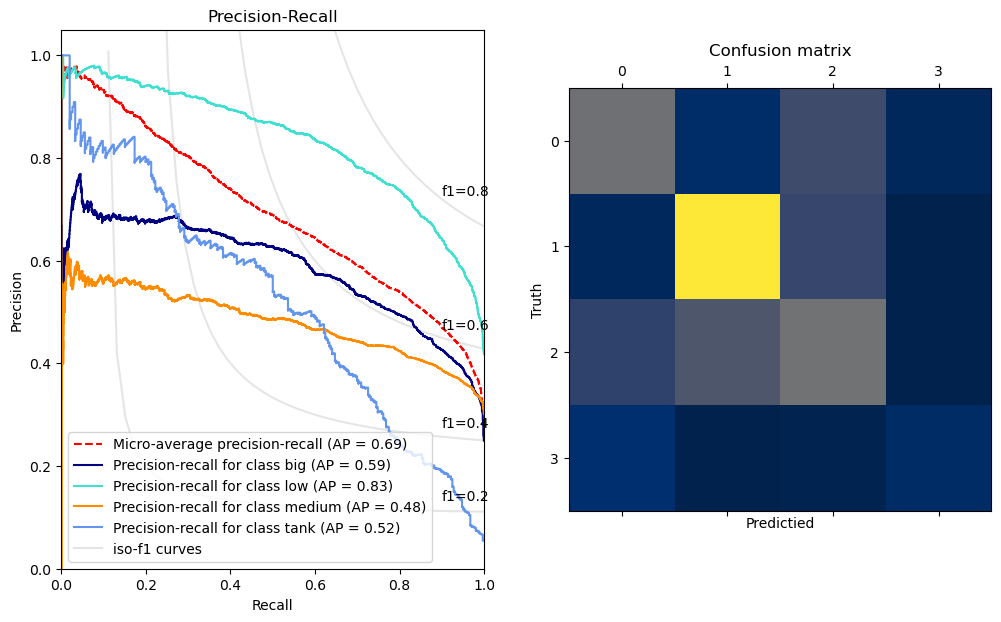

F1 score(average): 0.6293639406982305


In [18]:
dates_transformer_lgbm = Pipeline(steps=[
                    ("create_features",Dates_enginering("date_published")),
                    ("encode",OrdinalEncoder())
                    ])
cat_transformer_lgbm = OrdinalEncoder(unknown_value=999,handle_unknown='use_encoded_value')
lgbm_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer_lgbm,COLS_TO_ENCODE),
    ("dates",dates_transformer_lgbm,"date_published"),
    ("num","passthrough",["budget_adj","duration"])
])
lgbm = Pipeline(steps=[("preprocessor",lgbm_preprocessor),
                     ("clf",LGBMClassifier(n_jobs=-1,objective="multiclass",n_estimators=100))])
learning_rate = [0.1]
max_depth = [5,2,3]
num_leaves = [31]
param_grid = dict(clf__learning_rate=learning_rate,
                  clf__max_depth=max_depth,
                 clf__num_leaves=num_leaves)

lgbm_grid = GridSearchCV(lgbm,param_grid=param_grid,cv=5,verbose=0)
lgbm_grid.fit(df_train,y_train)

#mejor primer tirada :  {'estimator__clf__learning_rate': 0.1,
 #'estimator__clf__max_depth': 5,
 #'estimator__clf__num_leaves': 31}
#Segunda tirada msimos valores

models["lgbm"] = lgbm_grid.best_estimator_

get_results(model=models["lgbm"],X=df_train,y=y_train)

#### Neural Networks

In [24]:
#Build general model to search on grid
def general_model(optimizer="adagrad",
                   kernel_initializer="glorot_uniform",
                   dropout=0.1,hidden_layers=5,n_neurons=400,input_dim=669):
    model = Sequential()
    model.add(Dense(units=100,input_dim=input_dim,activation="relu"))
    for i in range(hidden_layers):
        model.add(Dense(n_neurons,activation="relu",kernel_initializer=kernel_initializer))
        model.add(Dropout(dropout))
    model.add(Dense(4,activation="softmax",kernel_initializer=kernel_initializer))
    model.compile(loss="categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
    return model
#Param grid
param_grid = dict()
dropout = [0.1]
hidden_layers = [5]
n_neurons = [400]
optimizer = ["adagrad"]
batch_size=[20]
param_grid = dict(
    clf__dropout=dropout,
    clf__hidden_layers=hidden_layers,
    clf__n_neurons=n_neurons,
    clf__optimizer=optimizer,   
    clf__batch_size=batch_size,

)    
#Preprocessing pipeline columns
dates_transformer_nn = Pipeline(steps=[
                    ("create_features",Dates_enginering("date_published")),
                    ("encode",OneHotEncoder(sparse=False,handle_unknown="ignore"))
                    ])
num_transformer = StandardScaler()
cat_transformer_nn = OneHotEncoder(sparse=False,handle_unknown="ignore")
nn_preprocessor = ColumnTransformer([
    ("encode_cat",cat_transformer_nn,COLS_TO_ENCODE),
    ("dates",dates_transformer_nn,"date_published"),
    ("num",num_transformer,["budget_adj","duration"])
])
#Sklearn wrapper
nn_clf = KerasClassifier(build_fn=general_model)

#Complete pipeline
nn = Pipeline(steps=[("preprocessor",nn_preprocessor),
                     ("clf",nn_clf)])

#Create random search grid
nn_grid = GridSearchCV(nn,param_grid=param_grid,cv=3,verbose=3)
#Fit
nn_grid.fit(df_train,y_train)
models["nn"] = nn
#get_results(models["nn"],y=y_train,X=df_train)
#Primera tirada:
#best_params_1 = {'clf__optimizer': 'adagrad',
# 'clf__n_neurons': 472,
# 'clf__hidden_layers': 5,
# 'clf__dropout': 0.1,
# 'clf__batch_size': 20}
#best_score_1 = 0.659
#Segunda tirada: Mismos valores
#Tercera tirada:
#{'clf__batch_size': 20,
# 'clf__dropout': 0.1,
# 'clf__hidden_layers': 5,
# 'clf__n_neurons': 400,
# 'clf__optimizer': 'adagrad'}
#0.66
#cuarta: {'clf__batch_size': 20,
# 'clf__dropout': 0.1,
#'clf__hidden_layers': 6,
#clf__n_neurons': 400,
#'clf__optimizer': 'adagrad'}



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END clf__batch_size=20, clf__dropout=0.1, clf__hidden_layers=5, clf__n_neurons=400, clf__optimizer=adagrad;, score=nan total time=   0.1s
210/210 [==============================] - 2s 8ms/step - loss: 1.3629 - accuracy: 0.3623
[CV 2/3] END clf__batch_size=20, clf__dropout=0.1, clf__hidden_layers=5, clf__n_neurons=400, clf__optimizer=adagrad;, score=nan total time=   2.1s
[CV 3/3] END clf__batch_size=20, clf__dropout=0.1, clf__hidden_layers=5, clf__n_neurons=400, clf__optimizer=adagrad;, score=nan total time=   0.1s


/home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "/home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/sklearn/pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "/home/joaquim/miniconda3/e

ValueError: in user code:

    /home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/joaquim/miniconda3/envs/movie/lib/python3.9/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_23 is incompatible with the layer: expected axis -1 of input shape to have value 669 but received input with shape (None, 673)


In [6]:
models["nn"]._estimator_type

'classifier'

#### Stacking WORK ON PROGRESS

In [9]:
estimators = [("rf",models["rf"]),
             ("lgbm",models["lgbm"]),
             ("nn",models["nn"])]
final_estimator = RandomForestClassifier(n_jobs=-1)

stack_clf = StackingClassifier(estimators=estimators,final_estimator=final_estimator)

cross_val_score(stack_clf,df_train,y_train,cv=3)

C:\Users\joaco\anaconda3\envs\movieIndustrieEnv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\joaco\anaconda3\envs\movieIndustrieEnv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\joaco\anaconda3\envs\movieIndustrieEnv\lib\site-packages\sklearn\ensemble\_stacking.py", line 488, in fit
    return super().fit(X, self._le.transform(y), sample_weight)
  File "C:\Users\joaco\anaconda3\envs\movieIndustrieEnv\lib\site-packages\sklear

array([nan, nan, nan])

### DEPLOYING (WORK ON PROGRESS)

In [23]:
joblib.dump(value=rf_grid.best_estimator_,filename="rf.joblib",compress=True)

['rf.joblib']

In [ ]:
rf = RandomForestClassifier(max_depth=90,min_samples_split=4)
COLS_TO_ENCODE = ['genre0','writer','language',"country","director",
                  "actors0","production_company"]
DATE_COLUMN = "date_published"
dates_transformer_rf = Pipeline(steps=[
                    ("create_features",Dates_enginering("date_published")),
                    ("encode",OrdinalEncoder())
                    ])
cat_transformer_rf = OrdinalEncoder()
rf_preprocessor = ColumnTransformer([
            ("encode_cat",cat_transformer_rf,COLS_TO_ENCODE),
            ("dates",dates_transformer_rf,DATE_COLUMN),
            ("num","passthrough",["budget_adj","duration"])
        ])

#rf_pipe =  Pipeline(steps=[("preprocessor",rf_preprocessor)])
rf_data = rf_preprocessor.fit_transform(df_train)
rf.fit(rf_data,y_train)
joblib.dump(rf,"./rf_v1.joblib",compress=True)

['./rf_v1.joblib']

In [15]:
# fit all transformers

#save them

#create RF class

RandomForestClassifier(max_depth=90, min_samples_split=4)

In [ ]:
class RandomForestClassifier():
    def __init__(self):
        path_to_artifacts = "../../research/"
        #the random forest is alrady a sklearn pipeline with preprocessors
        self.rf = joblib.load("rf_v1.joblib")
        self.labels = joblib.load("label_encoders.joblib")
    def preprocess(self):
        input_data = pd.DataFrame(input_data)
        COLS_TO_ENCODE = ['genre0','writer','language',"country","director",
                  "actors0","production_company"]
        DATE_COLUMN = "date_published"
        dates_transformer_rf = Pipeline(steps=[
                    ("create_features",Dates_enginering("date_published")),
                    ("encode",OrdinalEncoder())
                    ])
        cat_transformer_rf = OrdinalEncoder()
        rf_preprocessor = ColumnTransformer([
            ("encode_cat",cat_transformer_rf,COLS_TO_ENCODE),
            ("dates",dates_transformer_rf,DATE_COLUMN),
            ("num","passthrough",["budget_adj","duration"])
        ]) 
        input_data = rf
    def predict(self,input_data):

        try:
            results = dict()
            results["probability"] = self.rf.predict_proba(input_data)
            results["prediction"] = self.labels.inverse_transform(
                                    self.rf.predict(input_data)
                                    )
        except Exception as e:
            return {"status":"Error","message":str(e)}
        return results

In [ ]:
rf.fit(df_train,y_train)

AttributeError: 'RandomForestClassifier' object has no attribute 'fit'

In [ ]:
rf["clf"]

RandomForestClassifier(n_jobs=-1)

##### RF for deploy

In [ ]:
rf_encoders = dict()

# for each column save a in a dict every transformer
for column  in COLS_TO_ENCODE:
    rf_encoders[column] = cat_transformer_rf
rf_encoders["date_published"] = dates_transformer_rf
for column in ["budget_adj","duration"]:
    rf_encoders[column] = StandardScaler().fit(df_train[[column]])
   

In [ ]:
models["rf"]["clf"]

RandomForestClassifier(max_depth=90, min_samples_split=4, n_jobs=-1)